In [1]:
import numpy as np
from scipy.linalg import solve_discrete_are
import cvxpy as cp
from algorithms import policy_fitting, policy_fitting_with_a_kalman_constraint
import warnings
import random
# warnings.filterwarnings('ignore')

In [2]:
np.random.seed(0)
n, m = 4, 2
A = np.random.randn(n, n)
A = A / np.abs(np.linalg.eig(A)[0]).max()
B = np.random.randn(n, m)
W = .25 * np.eye(n)
Q_true = np.eye(n)
R_true = np.eye(m)
P_true = solve_discrete_are(A, B, Q_true, R_true)
K_true = -np.linalg.solve(R_true + B.T @ P_true @ B, B.T @ P_true @ A)

In [3]:
def simulate(K, N=10, seed=None, add_noise=False):
    if seed is not None:
        np.random.seed(seed)
    x = np.random.multivariate_normal(np.zeros(n), W)
    xs = []
    us = []
    cost = 0.0
    for _ in range(N):
        u = K @ x
        if add_noise:
            u += np.random.randn(m)
            for i in range(m):
                if random.random() < .1:
                    u[i] *= -1.
        xs.append(x)
        us.append(u)
        cost += (x @ Q_true @ x + u @ R_true @ u) / N
        x = A @ x + B @ u + np.random.multivariate_normal(np.zeros(n), W)
    xs = np.array(xs)
    us = np.array(us)
    
    return cost, xs, us

In [4]:
N_test = 10000
cost_true = simulate(K_true, N=N_test, seed=0)[0]
cost_noise = simulate(K_true, N=N_test, seed=0, add_noise=True)[0] 
cost_true, np.trace(P_true @ W), cost_noise

(1.7934243186095473, 1.8031177219720198, 18.825952044444772)

In [5]:
costs_lr = []
costs_admm = []
Ns = np.arange(1, 51)
for N in Ns:
    costs_lr += [[]]
    costs_admm += [[]]
    for k in range(1, 11):
        _, xs, us = simulate(K_true, N=N, seed=k, add_noise=True)

        def L(K):
            return cp.sum(cp.huber(xs @ K.T - us, .5))

        def r(K):
            return .01 * cp.sum_squares(K), []
        
        Klr = policy_fitting(L, r, xs, us)
        Kadmm = policy_fitting_with_a_kalman_constraint(L, r, xs, us, A, B, n_random=5)
        
        cost_lr = simulate(Klr, N=N_test, seed=0)[0]
        cost_admm = simulate(Kadmm, N=N_test, seed=0)[0]
        
        if np.isnan(cost_lr) or cost_lr > 1e5 or cost_lr == np.inf:
            cost_lr = np.nan

        costs_lr[-1].append(cost_lr)
        costs_admm[-1].append(cost_admm)

    print (" %03d | %3.3f | %3.3f | %3.3f | %3.3f" %
           (N, cost_true, cost_noise, np.nanmean(costs_lr[-1]), np.nanmean(costs_admm[-1])))

/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ip

 001 | 1.793 | 18.826 | 19.851 | 9.973


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in add
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in m

 002 | 1.793 | 18.826 | 5.620 | 5.763


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ip

 003 | 1.793 | 18.826 | 166.644 | 8.550


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipyk

 004 | 1.793 | 18.826 | 327.891 | 7.128


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in add
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: 

 005 | 1.793 | 18.826 | 120.741 | 3.498


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python

 006 | 1.793 | 18.826 | 12.003 | 5.420


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ip

 007 | 1.793 | 18.826 | 72.808 | 3.307


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
/home/shane/miniconda3/lib/python3.7/site-pac

 008 | 1.793 | 18.826 | 15.674 | 3.350


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in add
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in matmul
  if __name__ == '__main__':
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in matmul


 009 | 1.793 | 18.826 | 14.730 | 4.215
 010 | 1.793 | 18.826 | 5.585 | 2.484
 011 | 1.793 | 18.826 | 9.137 | 2.579
 012 | 1.793 | 18.826 | 9.000 | 2.352


/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in add
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in matmul
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in add
/home/shane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul


 013 | 1.793 | 18.826 | 4.784 | 2.837
 014 | 1.793 | 18.826 | 4.930 | 2.859
 015 | 1.793 | 18.826 | 4.367 | 2.670
 016 | 1.793 | 18.826 | 5.819 | 2.784
 017 | 1.793 | 18.826 | 4.695 | 2.331
 018 | 1.793 | 18.826 | 3.416 | 2.148
 019 | 1.793 | 18.826 | 3.570 | 2.450
 020 | 1.793 | 18.826 | 3.590 | 2.485
 021 | 1.793 | 18.826 | 3.466 | 2.063
 022 | 1.793 | 18.826 | 3.104 | 2.123
 023 | 1.793 | 18.826 | 3.514 | 2.418
 024 | 1.793 | 18.826 | 2.855 | 2.144
 025 | 1.793 | 18.826 | 3.681 | 2.290
 026 | 1.793 | 18.826 | 2.803 | 2.280
 027 | 1.793 | 18.826 | 2.945 | 2.452
 028 | 1.793 | 18.826 | 2.778 | 2.004
 029 | 1.793 | 18.826 | 2.564 | 2.078
 030 | 1.793 | 18.826 | 2.583 | 2.065
 031 | 1.793 | 18.826 | 2.538 | 2.060
 032 | 1.793 | 18.826 | 2.608 | 2.123
 033 | 1.793 | 18.826 | 2.891 | 2.185
 034 | 1.793 | 18.826 | 2.447 | 2.051
 035 | 1.793 | 18.826 | 2.484 | 2.097
 036 | 1.793 | 18.826 | 2.683 | 2.173
 037 | 1.793 | 18.826 | 2.853 | 2.350
 038 | 1.793 | 18.826 | 2.586 | 2.295
 039 | 1.793

In [6]:
costs_lr = np.array(costs_lr)
costs_admm = np.array(costs_admm)

In [7]:
mean_lr = np.nanmean(costs_lr, axis=1)
std_lr = np.nanstd(costs_lr, axis=1)

In [8]:
mean_admm = np.nanmean(costs_admm, axis=1)
std_admm = np.nanstd(costs_admm, axis=1)

In [9]:
mean_lr

array([ 19.85136756,   5.61997705, 166.64397772, 327.89137229,
       120.7414508 ,  12.00336894,  72.80848078,  15.67364983,
        14.72993345,   5.58489376,   9.13701609,   8.99987112,
         4.78404982,   4.92997576,   4.36697185,   5.81902745,
         4.69477217,   3.4159126 ,   3.57022764,   3.58970116,
         3.4662508 ,   3.10440512,   3.51392126,   2.85532066,
         3.68077351,   2.80306963,   2.94532632,   2.77751357,
         2.56392229,   2.58301185,   2.53829136,   2.60834125,
         2.89055114,   2.44683136,   2.48439126,   2.68338137,
         2.85286424,   2.58649843,   2.28417442,   2.35761311,
         2.60312829,   2.52092971,   2.35832966,   2.43887809,
         2.37325723,   2.33320615,   2.34356756,   2.55310942,
         2.46429187,   2.54712496])

In [10]:
mean_admm

array([9.97309684, 5.76299806, 8.55024743, 7.12844303, 3.49772278,
       5.41989861, 3.30719188, 3.34997022, 4.21527587, 2.48401557,
       2.57902735, 2.35229903, 2.83747542, 2.85910004, 2.67015718,
       2.78376978, 2.33050309, 2.14801305, 2.44979095, 2.48518447,
       2.06283547, 2.12264524, 2.41811337, 2.14355344, 2.29021443,
       2.27972515, 2.45229221, 2.00360365, 2.07812474, 2.06507117,
       2.06028601, 2.12274235, 2.18527623, 2.05075644, 2.0971895 ,
       2.17344276, 2.35042206, 2.29505439, 1.97625286, 2.08413764,
       2.18206624, 2.03810195, 2.05632705, 2.04897071, 2.04457984,
       2.00158468, 2.04448154, 2.04022634, 2.16323023, 2.09168326])

In [11]:
# mean_admm = np.load("mean_admm.npy")
# mean_lr = np.load("mean_lr.npy")
# std_admm = np.load("std_admm.npy")
# std_lr = np.load("std_lr.npy")
# costs_lr = np.load("costs_lr.npy")
# costs_admm = np.load("costs_admm.npy")

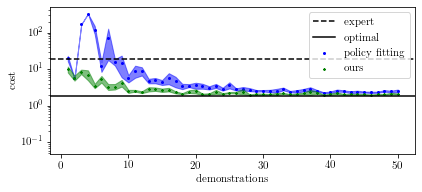

In [15]:
from utils import latexify
import matplotlib.pyplot as plt

plt.close()
latexify(fig_width=6, fig_height=2.8)
plt.axhline(cost_noise, ls='--', c='k', label='expert')
plt.scatter(np.arange(1,51), mean_lr, s=4, marker='o', c='blue', label='policy fitting')
plt.fill_between(np.arange(1,51), mean_lr - std_lr / 3, mean_lr + std_lr / 3, alpha=.5, color='blue')
plt.scatter(np.arange(1,51), mean_admm, s=4, marker='*', c='green', label='ours')
plt.fill_between(np.arange(1,51), mean_admm - std_admm / 3, mean_admm + std_admm / 3, alpha=.5, color='green')
plt.semilogy()
plt.axhline(cost_true, ls='-', c='k', label='optimal')
plt.ylabel('cost')
plt.xlabel('demonstrations')
plt.legend()
plt.tight_layout()
plt.savefig("figs/flip.pdf")
plt.show()

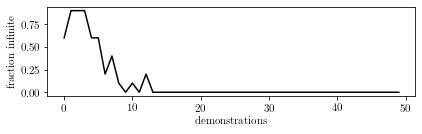

In [16]:
plt.close()
latexify(fig_width=6, fig_height=2)
plt.plot(np.isnan(costs_lr).mean(axis=1), c='k')
plt.xlabel("demonstrations")
plt.ylabel("fraction infinite")
plt.tight_layout()
plt.savefig("figs/inf_flip.pdf")